# Предсказване на изборни резултати в САЩ

## Идея
Анализирането на връзките между различни демографски фактори (като доходи, образование и етнически състав) и изборни резултати е от изключителна важност за придобиване на по-дълбоко разбиране на все по-поляризираната американска политическа сцена. Целта на този проект е анализирането на демографски данни и резултати от президентските избори през 2020 година в САЩ за всеки един окръг (county) или еквивалент на окръг (county equivalent) и създаването на модел, който предсказва резултата от избори за даден хипотетичен окръг. </br> </br>
*Терминология:* 
- **окръг (county)** - административна подединица на щат или територия в САЩ със строго определени географски граници и силно ограничена форма на автономност
- **еквивалент на окръг (county equivalent)** - поради исторически причини, в щатите Аляска и Луизиана терминът **окръг (county)** не се използва, а се използват респективно *боро (borough)* и *парохия (parish)*

Нека инсталираме нужните пакети:

In [1]:
install.packages(c("tidyverse", "tigris", "sf", "ggplot2", "gridExtra", "dplyr", "geojsonio"))
library(tidyverse)
library(tigris)
library(sf)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(geojsonio)
library(car)
library(MASS)

Installing packages into 'C:/Users/Teodor/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked
package 'tigris' successfully unpacked and MD5 sums checked
package 'sf' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'sf'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Teodor\AppData\Local\R\win-library\4.5\00LOCK\sf\libs\x64\sf.dll to C:\Users\Teodor\AppData\Local\R\win-library\4.5\sf\libs\x64\sf.dll: Permission denied"
Warning message:
"restored 'sf'"


package 'ggplot2' successfully unpacked and MD5 sums checked
package 'gridExtra' successfully unpacked and MD5 sums checked
package 'dplyr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'dplyr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Teodor\AppData\Local\R\win-library\4.5\00LOCK\dplyr\libs\x64\dplyr.dll to C:\Users\Teodor\AppData\Local\R\win-library\4.5\dplyr\libs\x64\dplyr.dll: Permission denied"
Warning message:
"restored 'dplyr'"


package 'geojsonio' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Teodor\AppData\Local\Temp\RtmpEXg0aZ\downloaded_packages


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Linking to GEOS 3.13.1, GDAL 3.11.0, PROJ 9.6.0; sf_use_s2() is TRUE


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: 'geojson

## Обработка на данни
Използвани са данни от [следния dataset в Kaggle](https://www.kaggle.com/datasets/essarabi/ultimate-us-election-dataset). </br>

In [2]:
data <- read.csv("data.csv")

Дадени са данни за всеки окръг от следния вид:

In [3]:
data[1, ]

,X,county,state,X2020.Democrat.vote.raw,X2020.Democrat.vote..,X2020.Republican.vote.raw,X2020.Republican.vote..,X2020.other.vote.raw,X2020.other.vote..,Population.with.less.than.9th.grade.education,⋯,NH.American.Indian.and.Alaska.Native.percentage,NH.Asian.percentage,NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage,NH.Some.Other.Race.percentage,NH.Two.or.More.Races.percentage,Percentage.engaged.in.Management..business..science..and.arts.occupations,Percentage.engaged.in.Service.Occupations,Percentage.engaged.in.Sales.and.Office,Percentage.engaged.in.Resources.and.Construction,Percentage.engaged.in.Transportation
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"Autauga County, Alabama",Autauga County,Alabama,7503,27.02,19838,71.44,429,1.54,1.70%,⋯,0.31,1.48,0.04,0.31,4.23,36.39,14.24,22.02,9.99,17.36


Тъй като някои от колоните, съдържащи проценти или числа, са дадени като низове, ще извършим съответните числови преобразувания за по-лесна работа впоследствие

In [4]:
nrow(data)

percentage_cols <- c("Population.with.less.than.9th.grade.education", "Population.with.9th.to.12th.grade.education..no.diploma", 
                     "High.School.graduate.and.equivalent", "Some.College.No.Degree", "Associates.Degree", "Bachelors.Degree", 
                     "Graduate.or.professional.degree")
data <- data %>%
    mutate(across(all_of(percentage_cols), ~ as.numeric(gsub("%", "", .))))

other_numeric_cols <- c("Median.income..dollars.", "Mean.income..dollars.")
data <- data %>%
    mutate(across(all_of(other_numeric_cols), ~ as.numeric(gsub(",", "", .))))

data <- na.omit(data)
nrow(data)

[1] 3143

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion"


[1] 3142

Преобразуваме и имената на щатите с имена с повече от 1 дума, тъй като те са дадени в PascalCase, вместо разделени с интервали по думи:

In [5]:
pascal_case_states <- c("NorthDakota", "SouthDakota", "NewMexico", "SouthCarolina", "NorthCarolina", "WestVirginia", "NewYork", "NewJersey", "NewHampshire", "RhodeIsland")
new_states <- c("North Dakota", "South Dakota", "New Mexico", "South Carolina", "North Carolina", "West Virginia", "New York", "New Jersey", "New Hampshire", "Rhode Island")

for (i in 1:length(pascal_case_states)) {
    data$state[which(data$state == pascal_case_states[i])] <- new_states[i]
}

## Колони

Променливите, с които ще работим, са:
- **county** - името на окръга
- **state** - щат, в който се намира окръга
- **X2020.Democrat.vote.raw** - общ брой гласове за кандидата на Демократическата партия (Джо Байдън) в даден окръг през 2020 година
- **X2020.Democrat.vote..** - процент гласове за кандидата на Демократическата партия (Джо Байдън) в даден окръг през 2020 година
- **X2020.Republican.vote.raw** - общ брой гласове за кандидата на Републиканската партия (Доналд Тръмп) в даден окръг през 2020 година
- **X2020.Republican.vote..** - процент гласове за кандидата на Републиканската партия (Доналд Тръмп) в даден окръг през 2020 година
- **X2020.other.vote.raw** - общ брой гласове за други кандидати в даден окръг през 2020 година
- **X2020.other.vote..** - процент гласове за други кандидати в даден окръг през 2020 година
- **Population.with.less.than.9th.grade.education** - процент население само с основно образование
- **Population.with.less.than.9th.to.12th.grade.education..no.diploma** - процент население с някаква форма на средно образование, но без диплома
- **High.School.graduate.and.equivalent** - процент население със средно образование
- **Some.College.No.Degree** - процент население с някаква форма на висше образование, но без диплома
- **Associates.Degree** - процент население със завършено двугодишно висше образование
- **Bachelors.Degree** - процент население с бакалавърска степен
- **Graduate.or.professional.degree** - процент население със степен, по-висока от бакалавър
- **Gini.Index** - индекс на Джини, който измерва неравенството в доходите; варира от 0 до 1, като 0 представлява перфектно равенство (всеки има едни и същи доходи), а 1 - перфектно неравенство (един човек има всички доходи в окръга, а останалите нямат нищо)
-  **Median.income..dollars.** - медианата на доходите
-  **Mean.income..dollars.** - средния доход
-  **Area.in.square.Km** - площ на окръга в квадратни километри
-  **Density.per.square.km** - гъстота на населението на квадратен километър
-  **Total.Population** - общо население
-  **Hispanic.or.Latino.percentage** / **NH.White.percentage** / **NH.Black.percentage** / **NH.American.Indian.and.Alaska.Native.percentage** / **NH.Asian.percentage** / **NH.Native.Hawaiian.and.Other.Pacific.Islander.percentage** / **NH.Some.Other.Race.percentage** / **NH.Two.or.More.Races.percentage** - процент латиноси/бели/черни/коренни жители/азиатци/хавайци/други/смесени в окръга
-  **Percentage.engaged.in.Management..business..science..and.arts.occupations** - процент работещи в управление, бизнес, наука и изкуства
-  **Percentage.engaged.in.Service.Occupations** - процент работещи в сектора на услугите
-  **Percentage.engaged.in.Sales.and.Office** - процент работещи в офиси
-  **Percentage.engaged.in.Resources.and.Construction** - процент работещи в първичния и вторичния сектор
-  **Percentage.engaged.in.Transportation** - процент работещи в сферата на транспорта

</br>
След направените промени по-горе, можем да изобразим изборните резултати на карта, използвайки респективно синьо и червено за Демократите и Републиканците, съгласно традицията за визуализация на резултати в САЩ:

Retrieving data for the year 2024



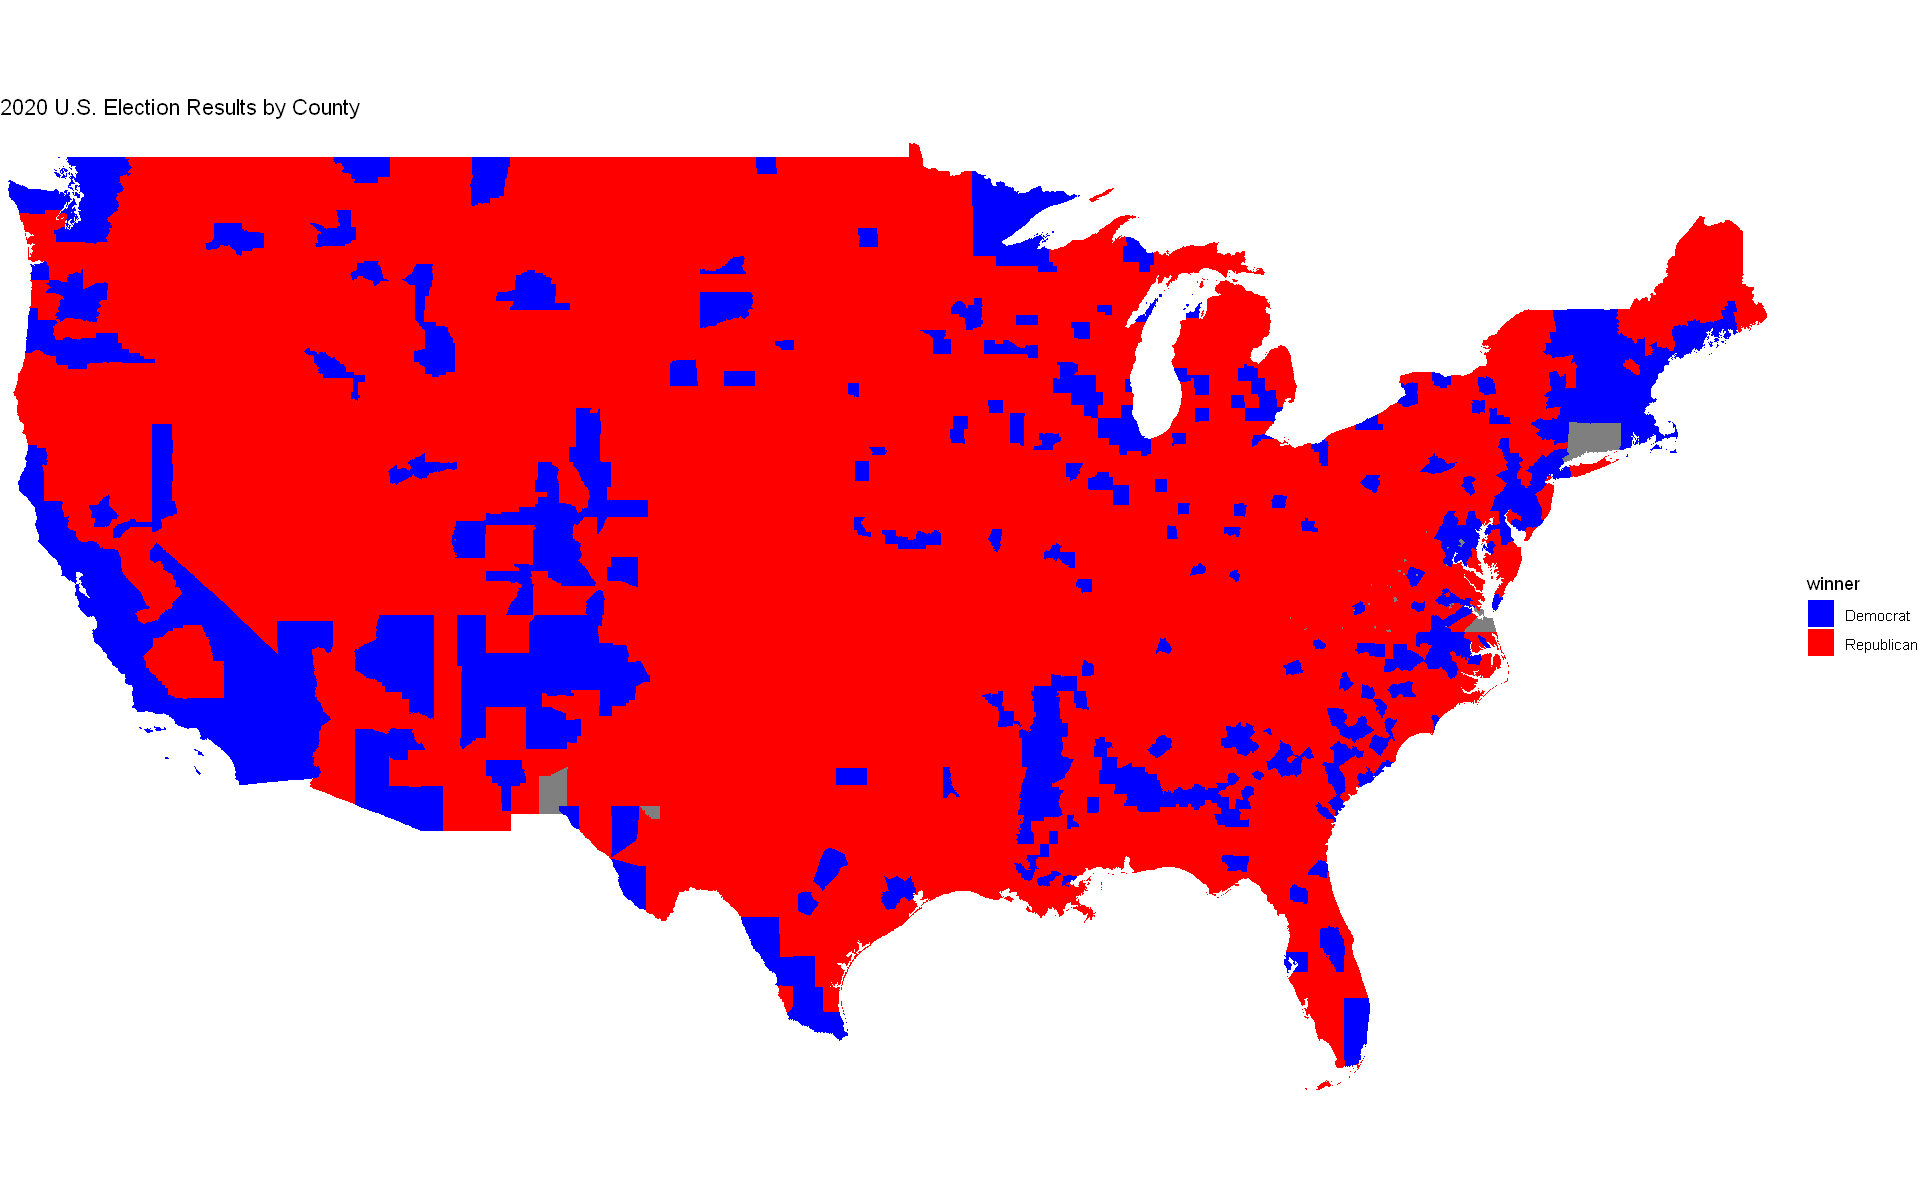

In [6]:
repl_data <- data %>%
  mutate(county = str_replace(county, " County", ""),
         state = str_trim(state)) %>%
  mutate(county = str_replace(county, " Parish", ""))

options(tigris_use_cache = TRUE)
counties_sf <- counties(cb = TRUE, class = "sf") %>%
  mutate(NAME = str_trim(NAME),
         STATE_NAME = str_trim(STATE_NAME))

map_data <- counties_sf %>%
  left_join(repl_data, by = c("NAME" = "county", "STATE_NAME" = "state"))

map_data <- map_data %>%
  mutate(winner = case_when(
    as.numeric(`X2020.Democrat.vote..`) > as.numeric(`X2020.Republican.vote..`) ~ "Democrat",
    as.numeric(`X2020.Republican.vote..`) > as.numeric(`X2020.Democrat.vote..`) ~ "Republican",
    TRUE ~ "Tie"
  ))

options(repr.plot.width = 16, repr.plot.height = 10)  
ggplot(map_data) +
  geom_sf(aes(fill = winner), color = NA) +
  scale_fill_manual(values = c("Democrat" = "blue", "Republican" = "red", "Tie / Error" = "gray")) +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE) +  
  theme_void() +
  labs(title = "2020 U.S. Election Results by County")

## Анализ за outlier-и

Ще разглеждаме *outlier* като данна, която не попада между минимума и максимума в един boxplot. Даваме минимума като разликата на първия квартил и 1.5\*IQR, а максимума като сбора на третия квартил и 1.5\*IQR, където IQR - interquartile range (интерквартилен размах)

Изследваме за outlier-и процентът гласували за Джо Байдън и Доналд Тръмп през 2020 година:

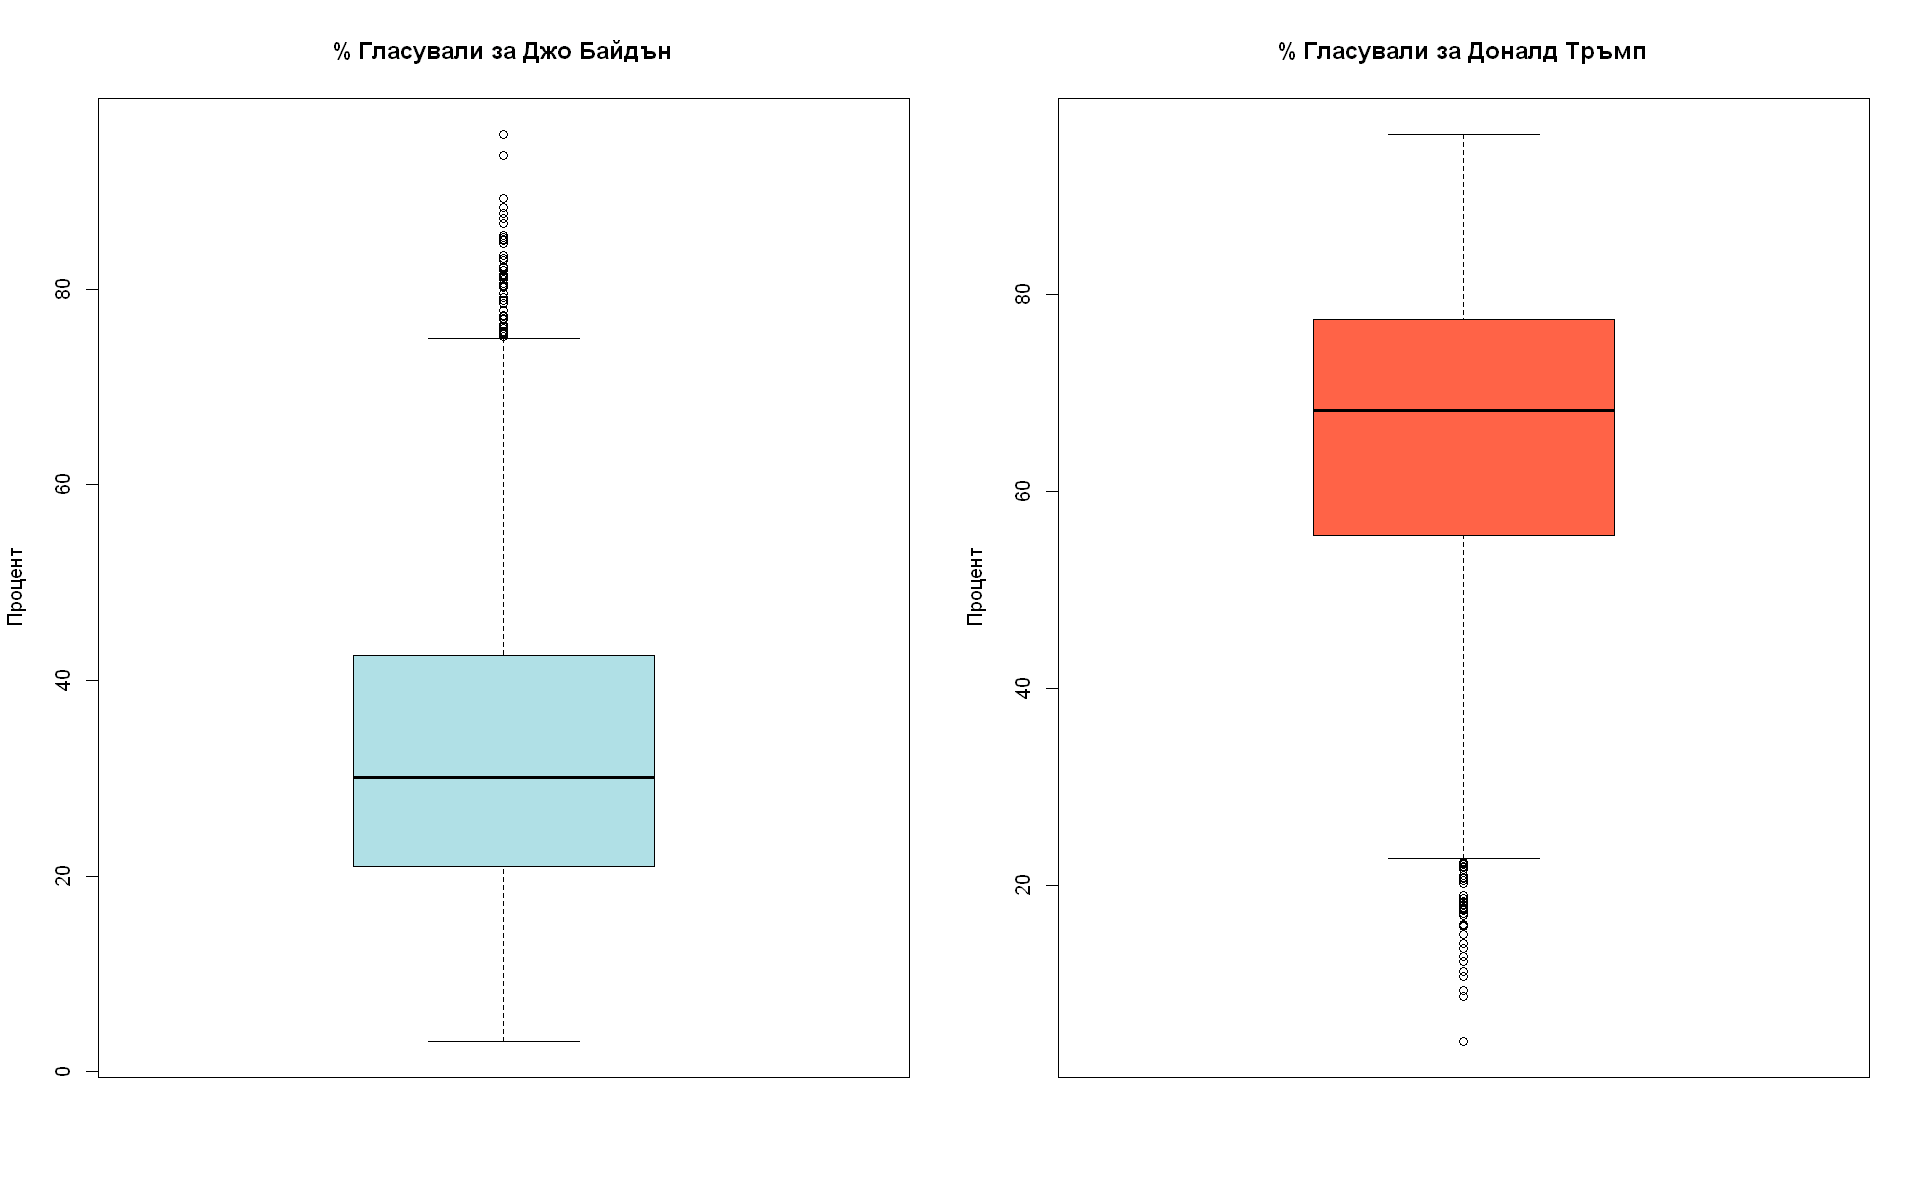

In [7]:
par(mfrow = c(1, 2))
boxplot(data$X2020.Democrat.vote.., col = "powderblue", main = "% Гласували за Джо Байдън", ylab = "Процент")
boxplot(data$X2020.Republican.vote.., col = "tomato", main = "% Гласували за Доналд Тръмп", 
        ylab = "Процент")
par(mfrow = c(1, 1))

Както се вижда, outlier-и има. Наличието на окръзи с толкова висок процент гласували за кандидат на Демократическата партия (над 70%), може да се обясни с това, че повечето от тези окръзи се намират в силно урбанизирани региони, в които населението е по-либерално настроено. </br>

Сега ще изследваме метриката за медиана на доходите по окръг. Тя е по-достоверна от тази за среден доход, тъй като outlier-ите в самото разпределение на доходите в даден окръг оказват по-голямо влияние на средната стойност, отколкото на медианата. Тоест, медианата е по-устойчива при наличие на outlier-и.

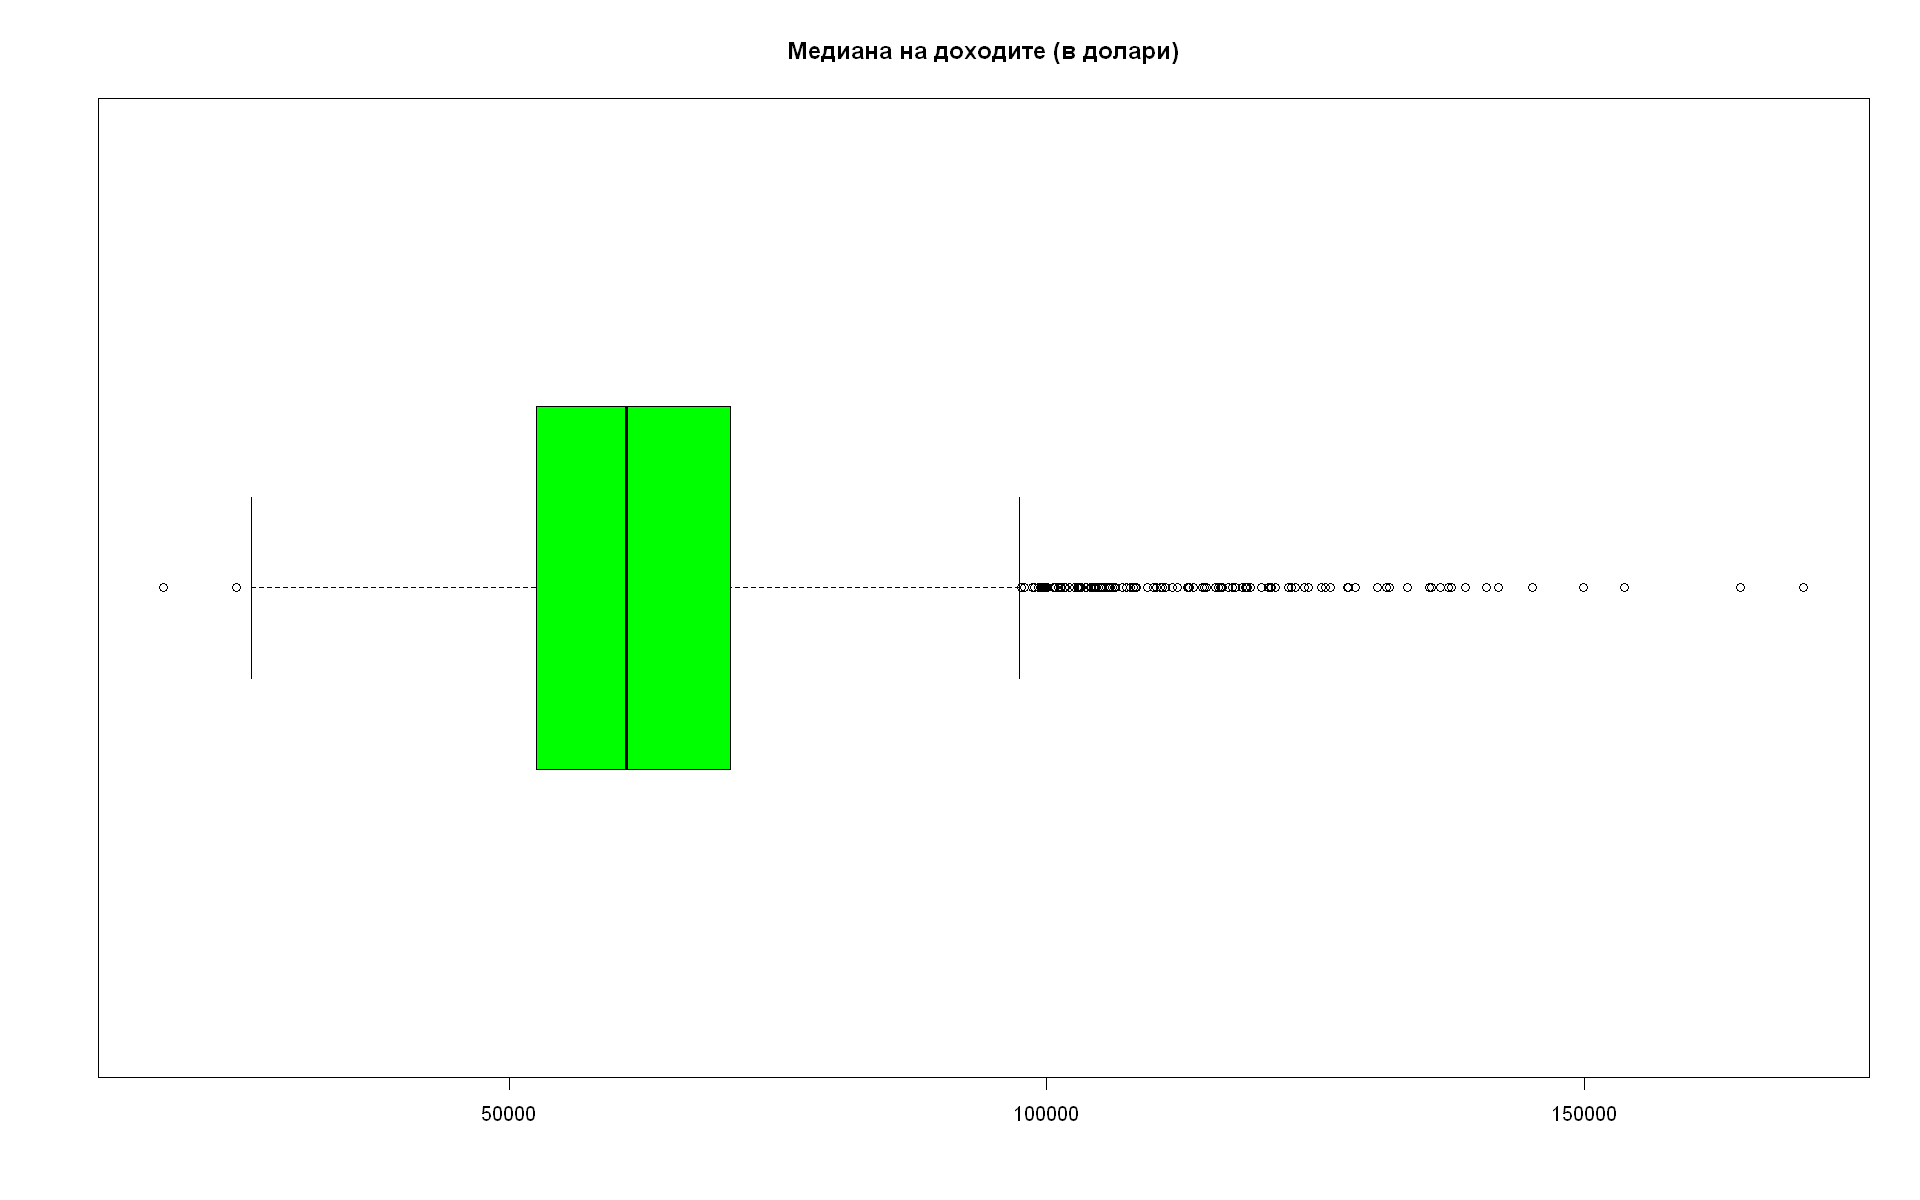

In [8]:
boxplot(data$Median.income..dollars., horizontal = T, col = "green", main = "Медиана на доходите (в долари)")

Както се вижда, и тук има outlier-и. Те са именно окръзите около Окръг Колумбия (D.C.), в които се намират много правителствени учреждения. </br> Нека тестваме за outlier-и също и населението на окръзите:

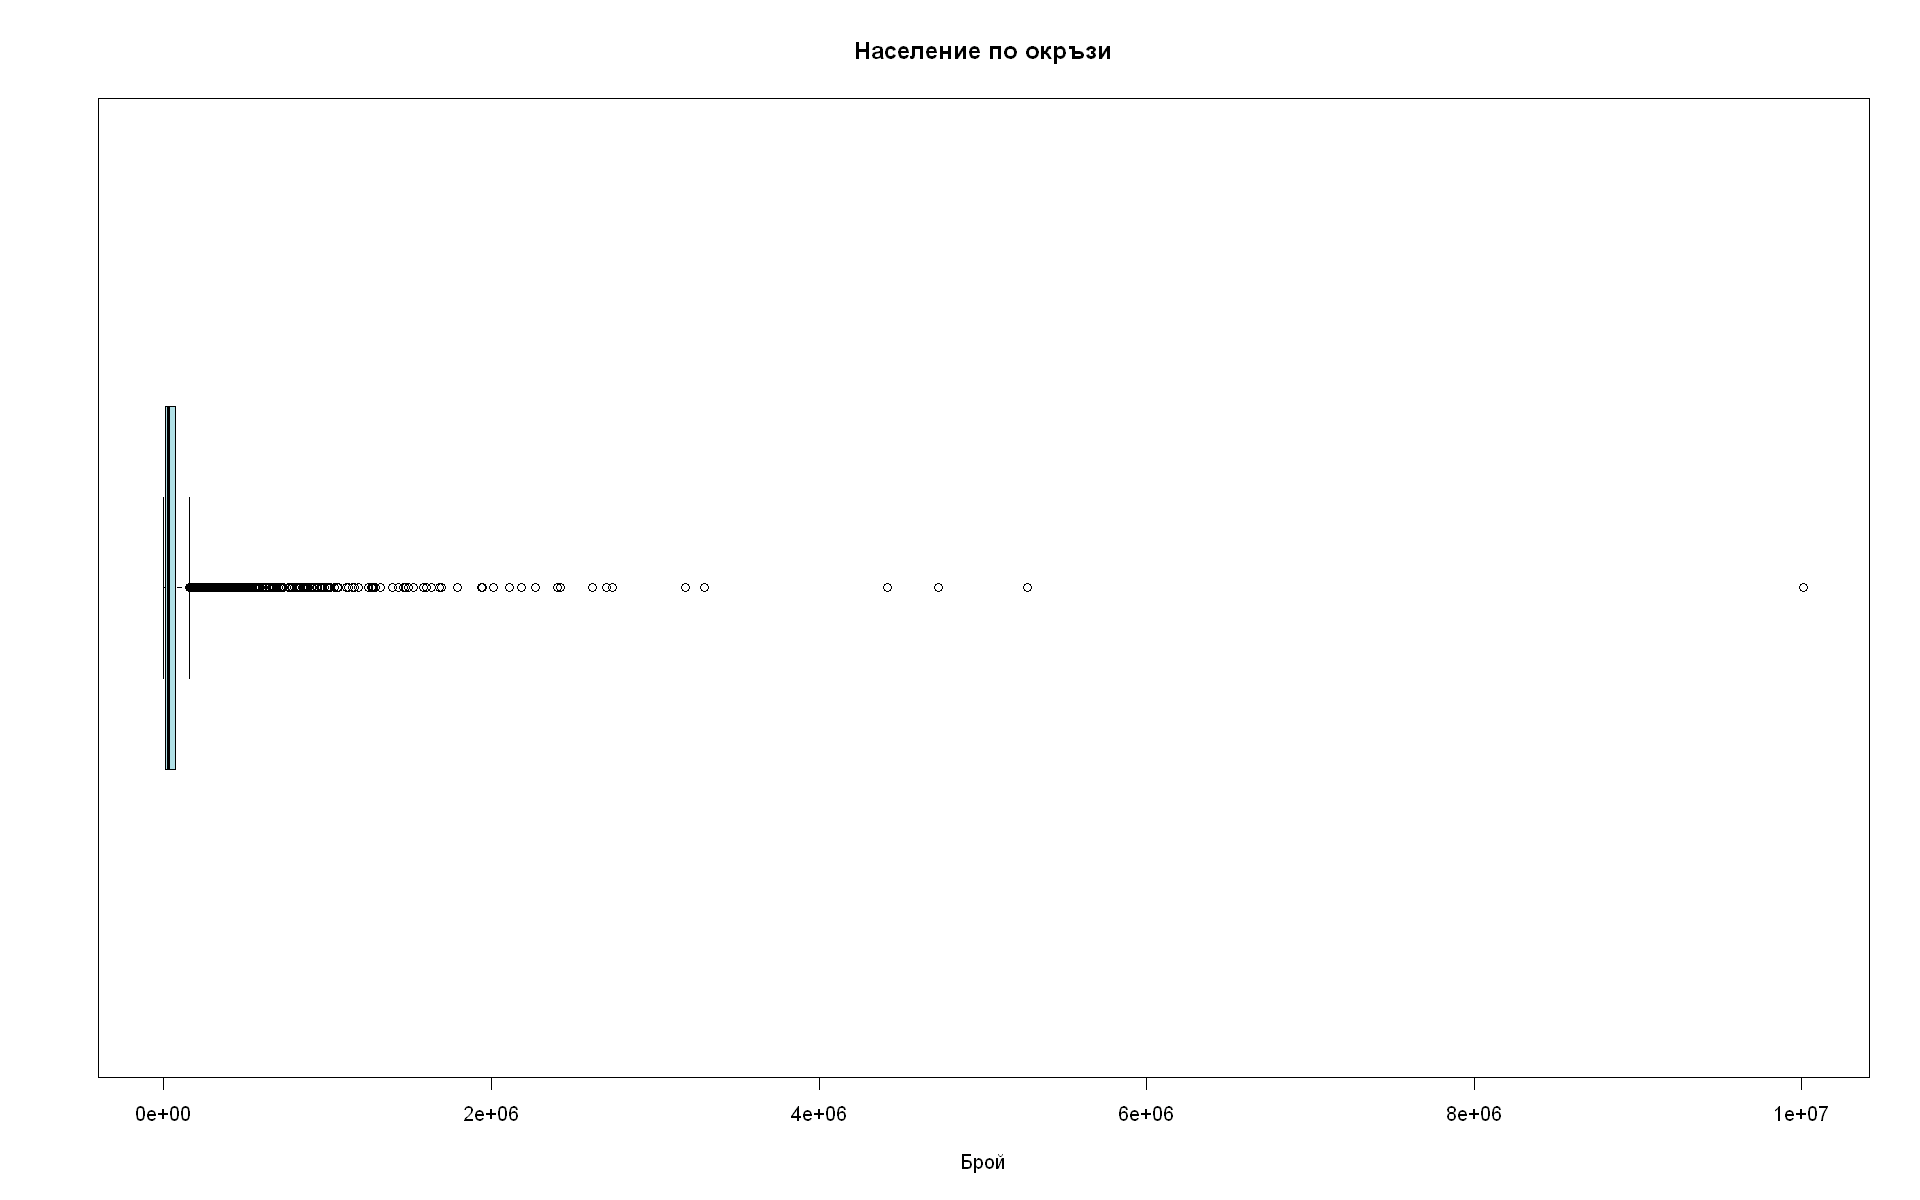

In [9]:
boxplot(data$Total.Population, horizontal = T, col = "powderblue", main = "Население по окръзи", xlab = "Брой")

Тук очевидно outlier-ите са много и това е така, поради факта, че по-големите метрополиси се разделят на много окръзи, но не винаги - има поне 4 интересни примера:
- цялата Los Angeles Metropolitan Area е обединена в един окръг с население над 10 милиона души (Los Angeles County)
- Чикаго е обединен в един окръг с население над 5 милиона души (Cook County)
- Хюстън е обединен в един окръг с население над 4.5 милиона души (Harris County)
- Финикс е обединен в един окръг с население над 4 милиона души (Maricopa County)

Последно, нека изследваме етническите показатели за outlier-и:

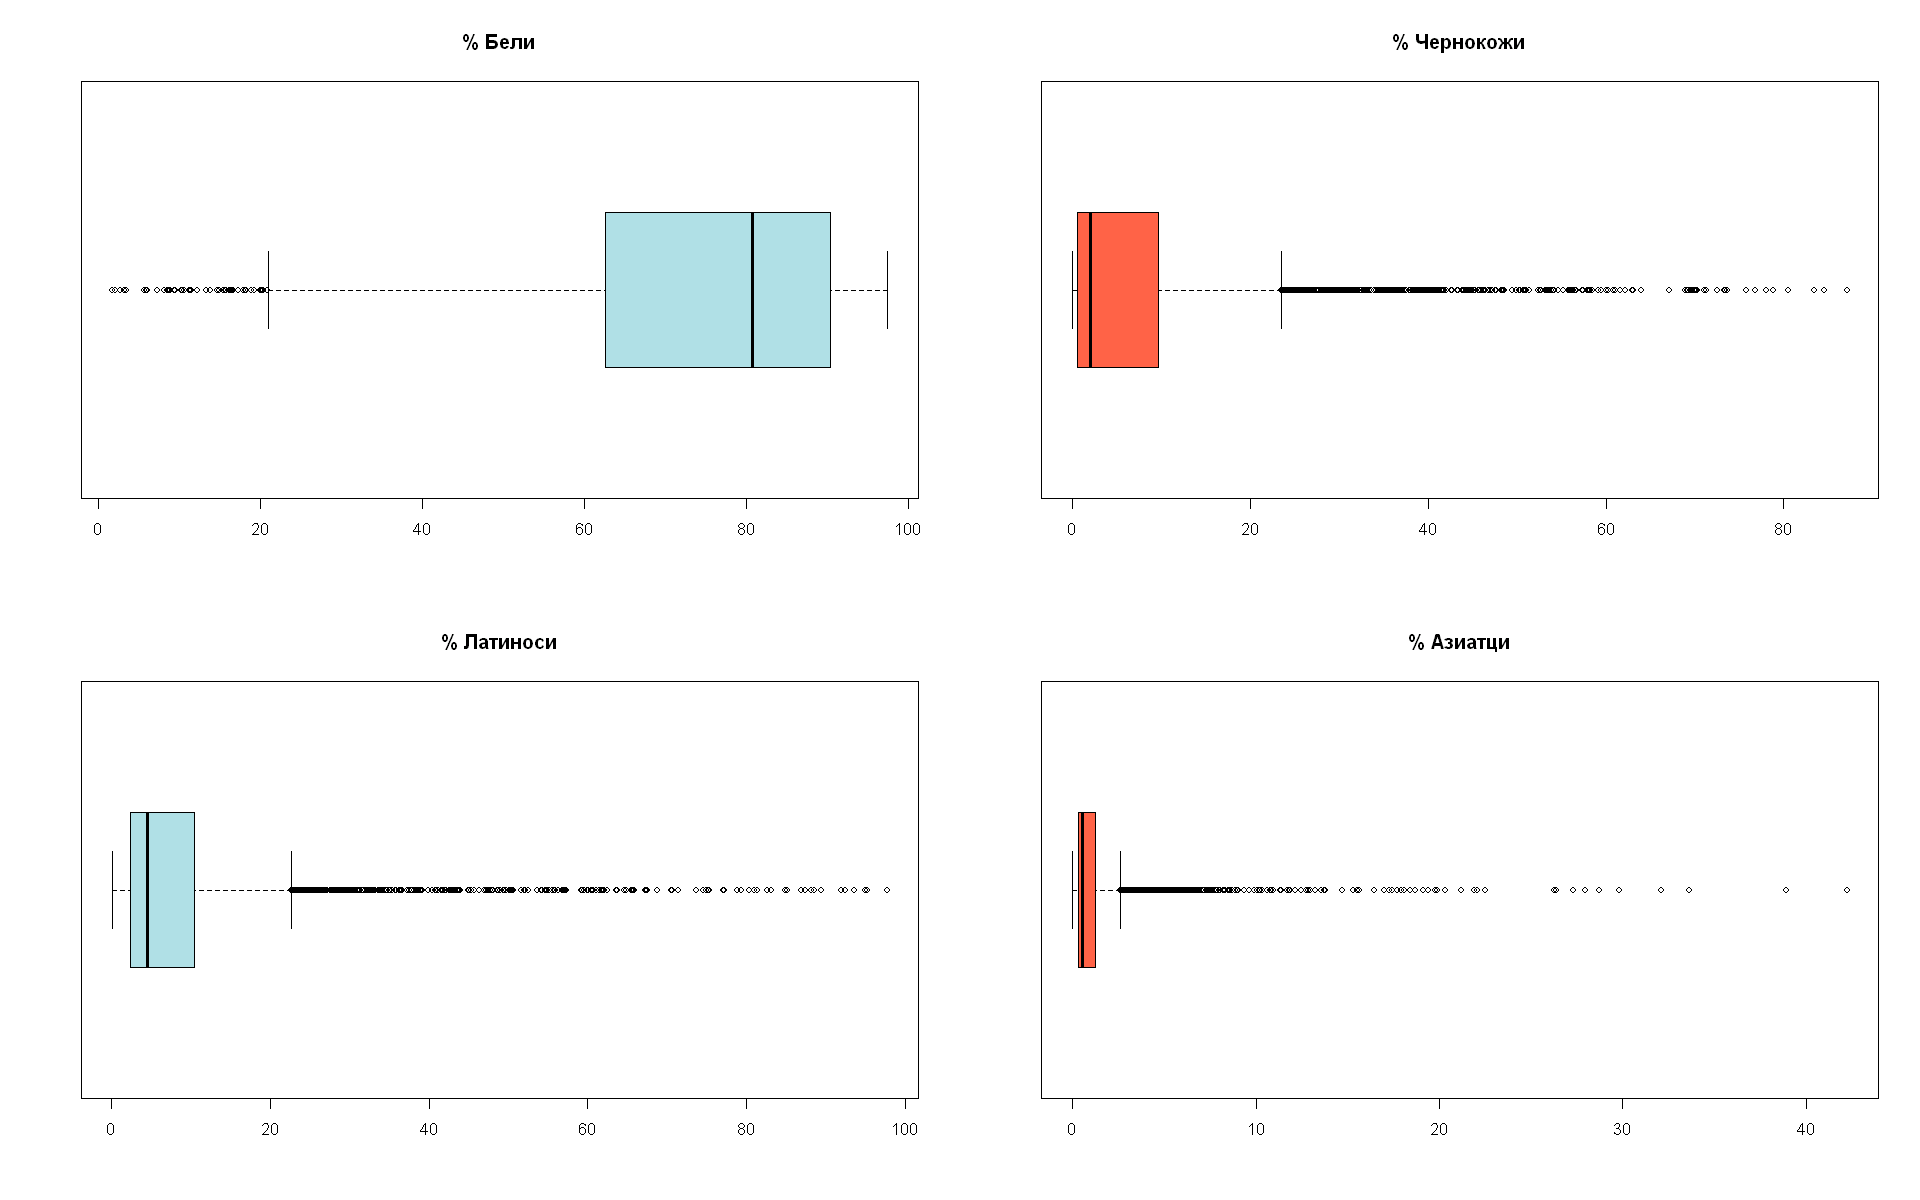

In [10]:
par(mfrow = c(2, 2))
boxplot(data$NH.White.percentage, horizontal = T, col = "powderblue", main = "% Бели")
boxplot(data$NH.Black.percentage, horizontal = T, col = "tomato", main = "% Чернокожи")
boxplot(data$Hispanic.or.Latino.percentage, horizontal = T, col = "powderblue", main = "% Латиноси")
boxplot(data$NH.Asian.percentage, horizontal = T, col = "tomato", main = "% Азиатци")
par(mfrow = c(1, 1))

Вижда се, че има връзка между процента бели в даден окръг и сборът от процентите на останалите групи - тази връзка ще проучим подробно по-надолу. Outlier-ите, показващи високи проценти чернокожи (70% и нагоре) са от сравнително слабо населени окръзи в южната част на САЩ (най-вече тези по поречието на река Мисисипи). Outlier-ите спрямо азиатското население са в окръзи като Хонолулу, Санта Клара и Сан Франциско, които са известни с многобройната си азиатска диаспора, а Outlier-ите спрямо латиносите са почти винаги окръзи на границата с Мексико, които по разбираеми причини имат доста висок процент (над 80-85%) латино население.

## Многомерен анализ и изследване на зависимости
Идеята тук е следната:
- ще разгледаме няколко графики (Q-Q plots и др.), за да видим графично връзки между различни променливи
- ще направим тестове за нормалност на променливите, които ще използваме, за да знаем какви точно тестове за статистическа значимост и връзка да използваме
- ще направим тестове за статистическа зависимост

### Графично сравнение
Ще направим 3 по-очевидни сравнения за връзка между 2 променливи:
- процент гласували за Тръмп срещу процент гласували за Байдън
- процент жители с бакалавърска степен срещу медиана на доходите
- процент жители без основно образование срещу коефициента на Джини

`geom_smooth()` using formula = 'y ~ x'


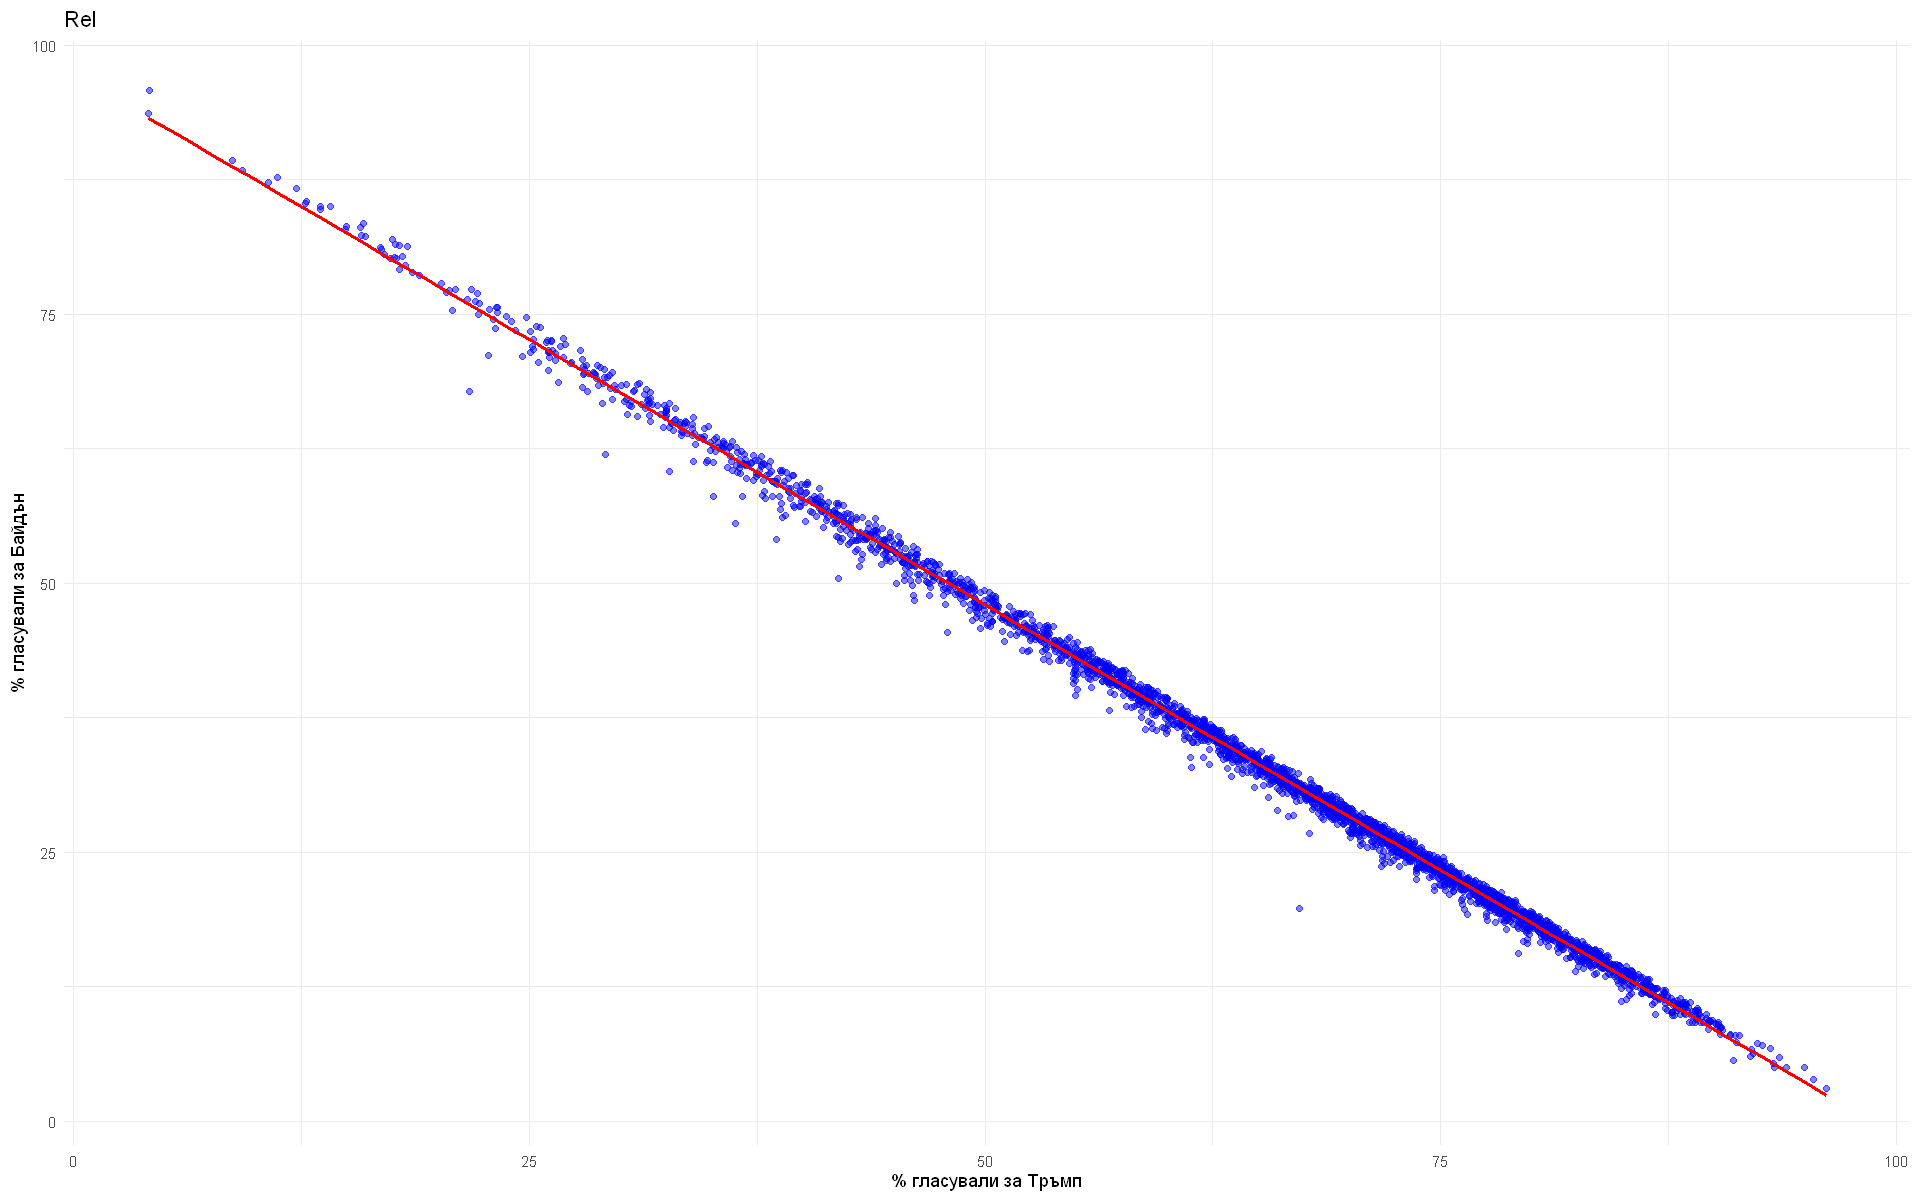

In [11]:
ggplot(data, aes(x = X2020.Republican.vote.., y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(title = "Rel", x = "% гласували за Тръмп", y = "% гласували за Байдън") + 
    theme_minimal()


Напълно очевидно, колкото по-голям процент хора гласуват за Тръмп, толкова по-малък процент хора гласуват за Байдън и обратното

`geom_smooth()` using formula = 'y ~ x'


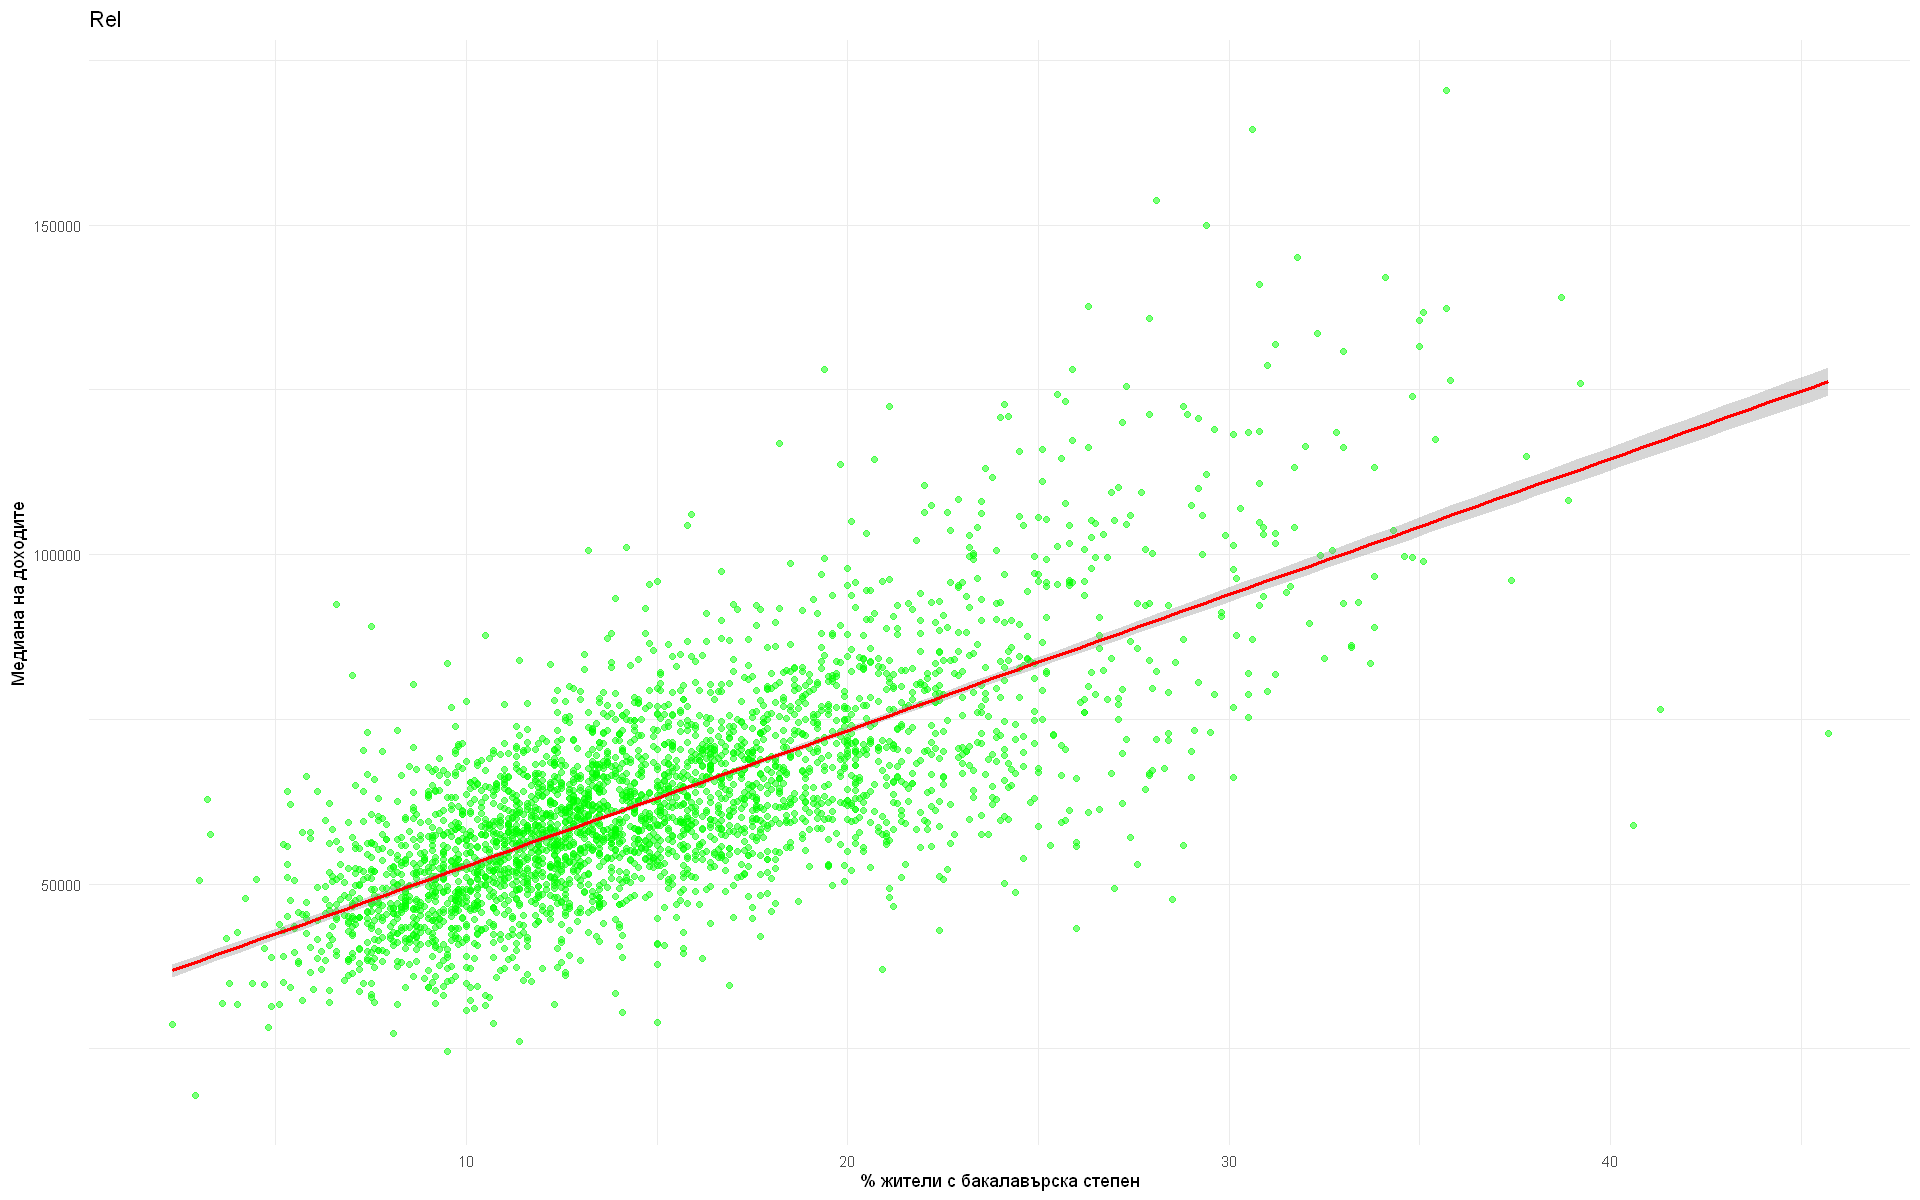

In [12]:
ggplot(data, aes(x = Bachelors.Degree, y = Median.income..dollars.)) + 
    geom_point(alpha = 0.5, color = "green") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(title = "Rel", x = "% жители с бакалавърска степен", y = "Медиана на доходите") + 
    theme_minimal()

Тук логично, с повишаването на процента хора с висше образование, се покачват и доходите на дадения окръг.

`geom_smooth()` using formula = 'y ~ x'


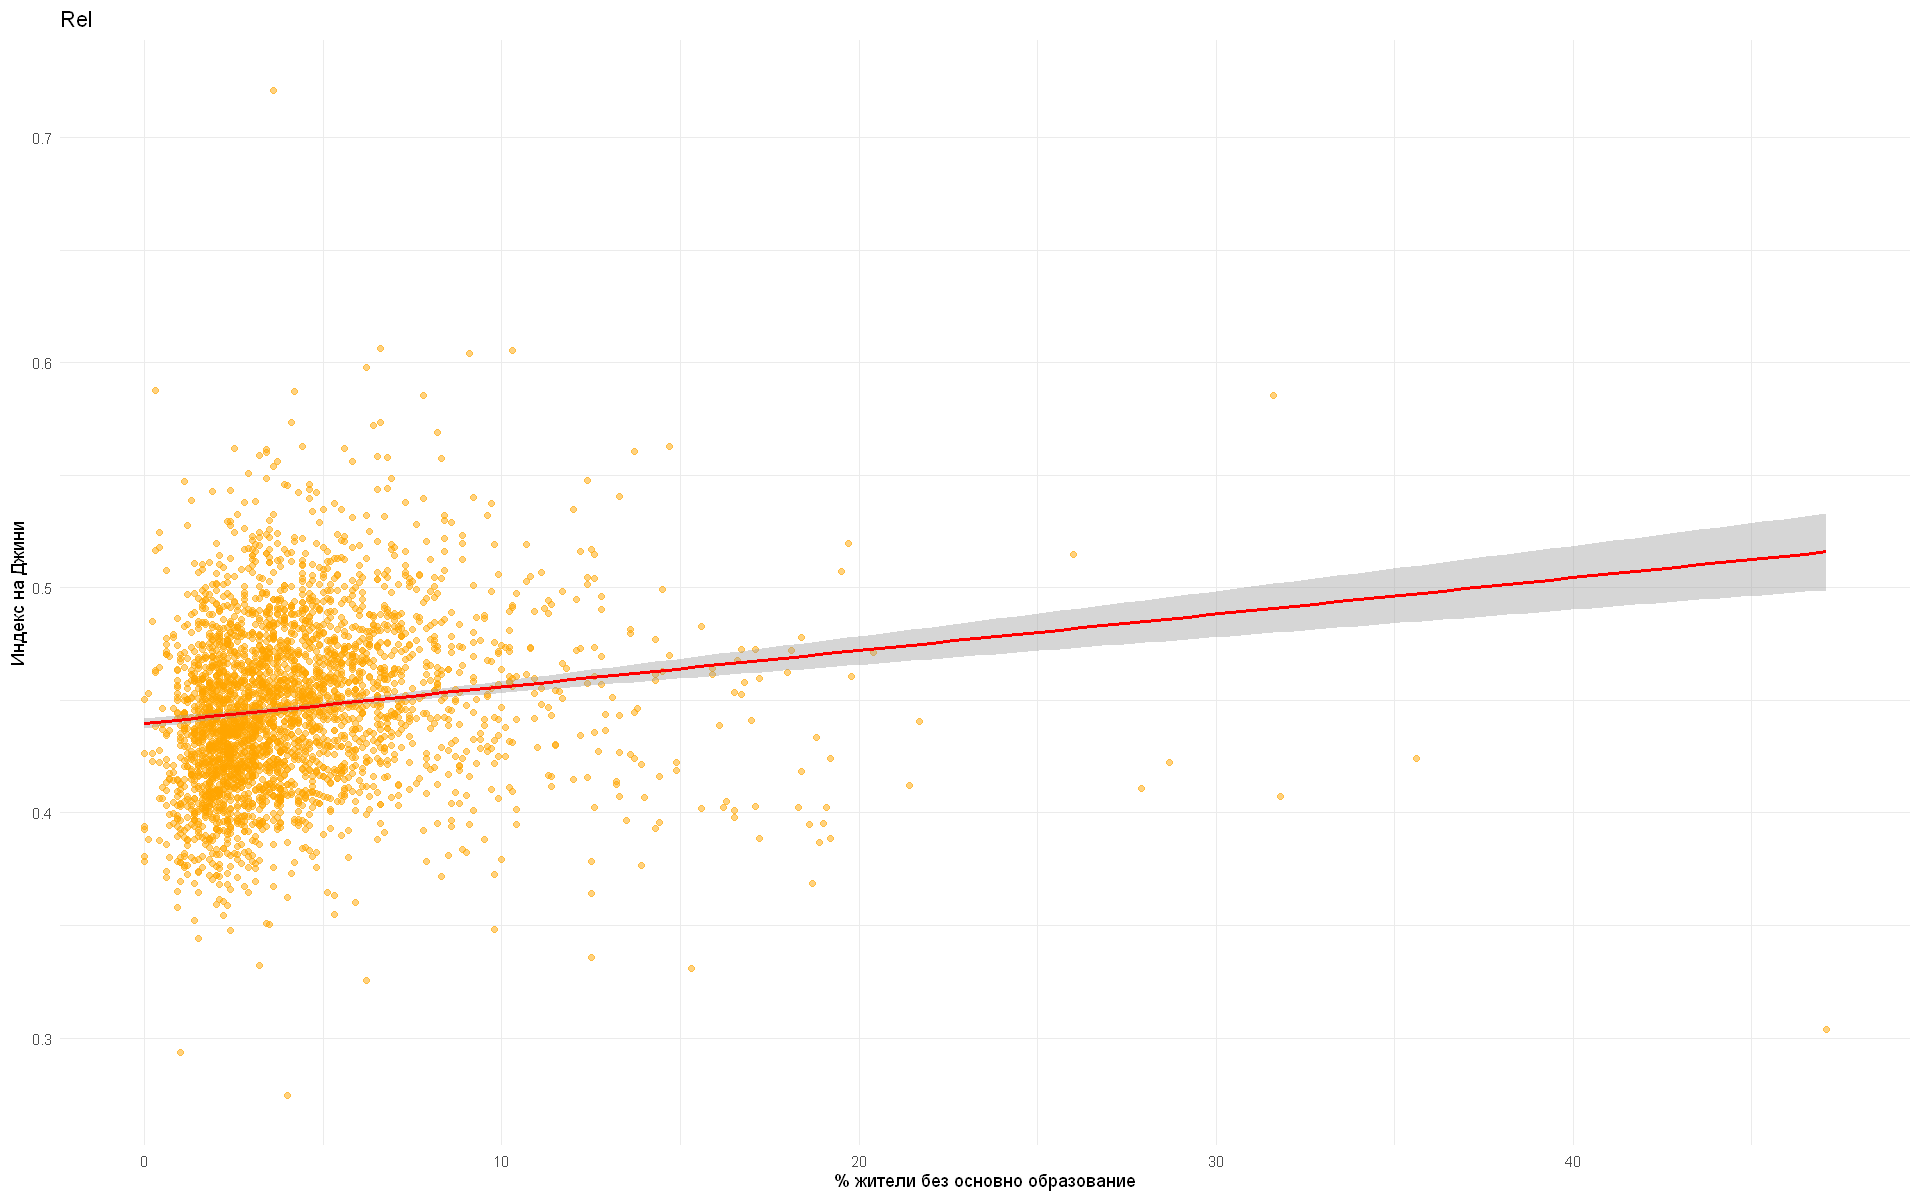

In [13]:
ggplot(data, aes(x = Population.with.less.than.9th.grade.education, y = Gini.Index)) + 
    geom_point(alpha = 0.5, color = "orange") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(title = "Rel", x = "% жители без основно образование", y = "Индекс на Джини") + 
    theme_minimal()

Тук виждаме, че коефициентът на Джини не зависи особено от процентът жители без основно образование, но въпреки това трендът е, че с увеличаването на този процент се увеличава и коефициентът на Джини (тоест се увеличава неравенството в доходите на даден окръг) </br> </br>

Ясно е, че тези връзки няма да ни помогнат особено при определянето на факторите, тъй като те са очевидни. Нека разгледаме няколко двойки променливи, които биха ни помогнали да направим модела за предсказване. Понеже САЩ е държава с де факто двупартийна система е почти същото дали ще анализираме резултатите на Демократите или на Републиканците.
- процент гласували за Демократите срещу процент хора с висше образование (бакалавър и по-нагоре)
- процент гласували за Демократите срещу индекса на Джини
- процент гласували за Демократите срещу медианата на доходите
- процент гласували за Демократите срещу процента бели
- процент гласували за Републиканците срещу сумата от проценти на малцинствата (всички, които не са бели)
- процент гласували за Демократите срещу процента чернокожи
- процент гласували за Демократите срещу процента латиноси
- процент гласували за Демократите срещу процент работещи в сферите на управлението, бизнеса, науката и изкуството
- процент гласували за Демократите срещу процент работещи в първичния и вторичния сектор

`geom_smooth()` using formula = 'y ~ x'


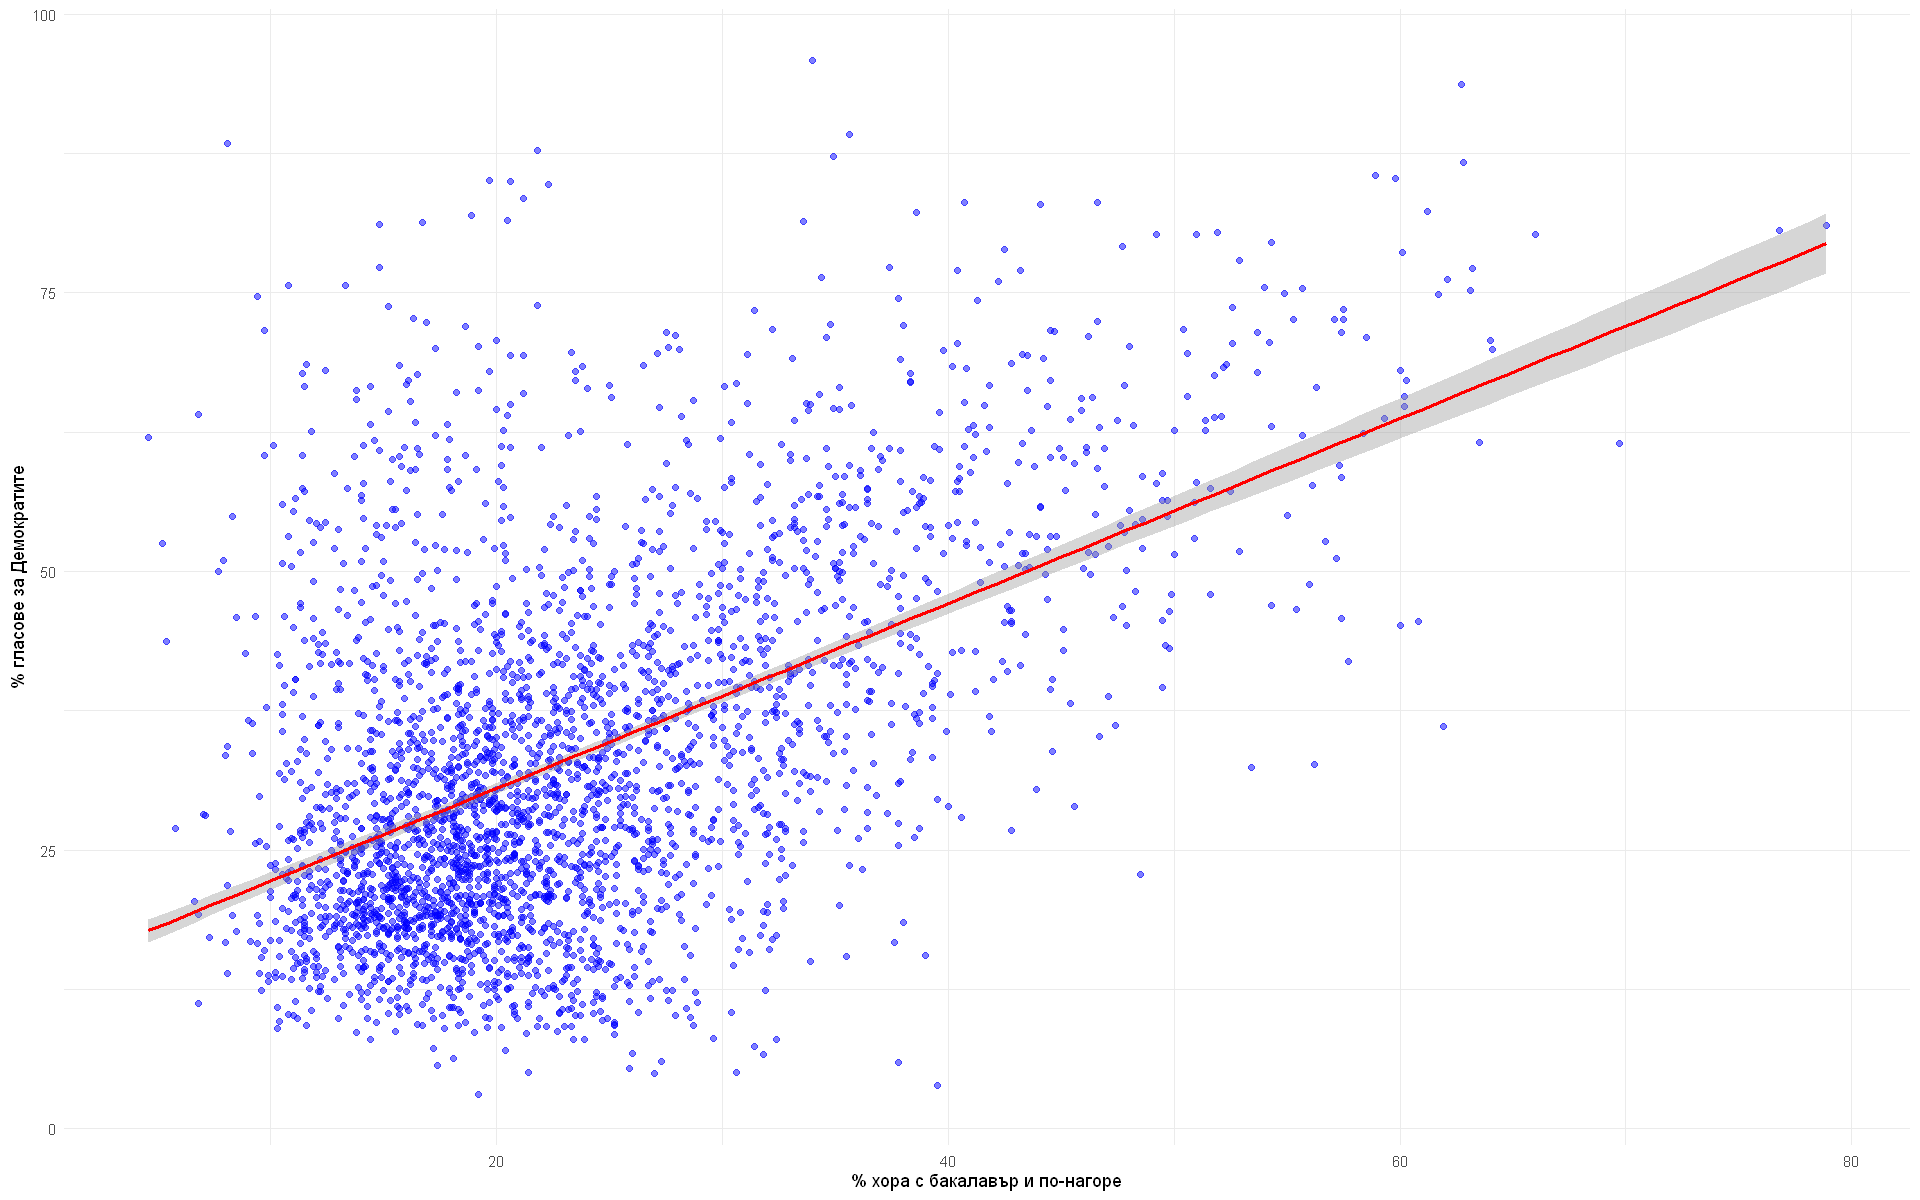

In [14]:
ggplot(data, aes(x = Bachelors.Degree + Graduate.or.professional.degree, y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(x = "% хора с бакалавър и по-нагоре", y = "% гласове за Демократите") + 
    theme_minimal()

Графиката тук показва следното: увеличението на процента гласове за Демократите не предопределя висок процент хора с висше образование, но обратното е в сила - колкото повече се увеличава процента на хората с висше образование, забелязваме увеличение в гласовете за Демократите

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


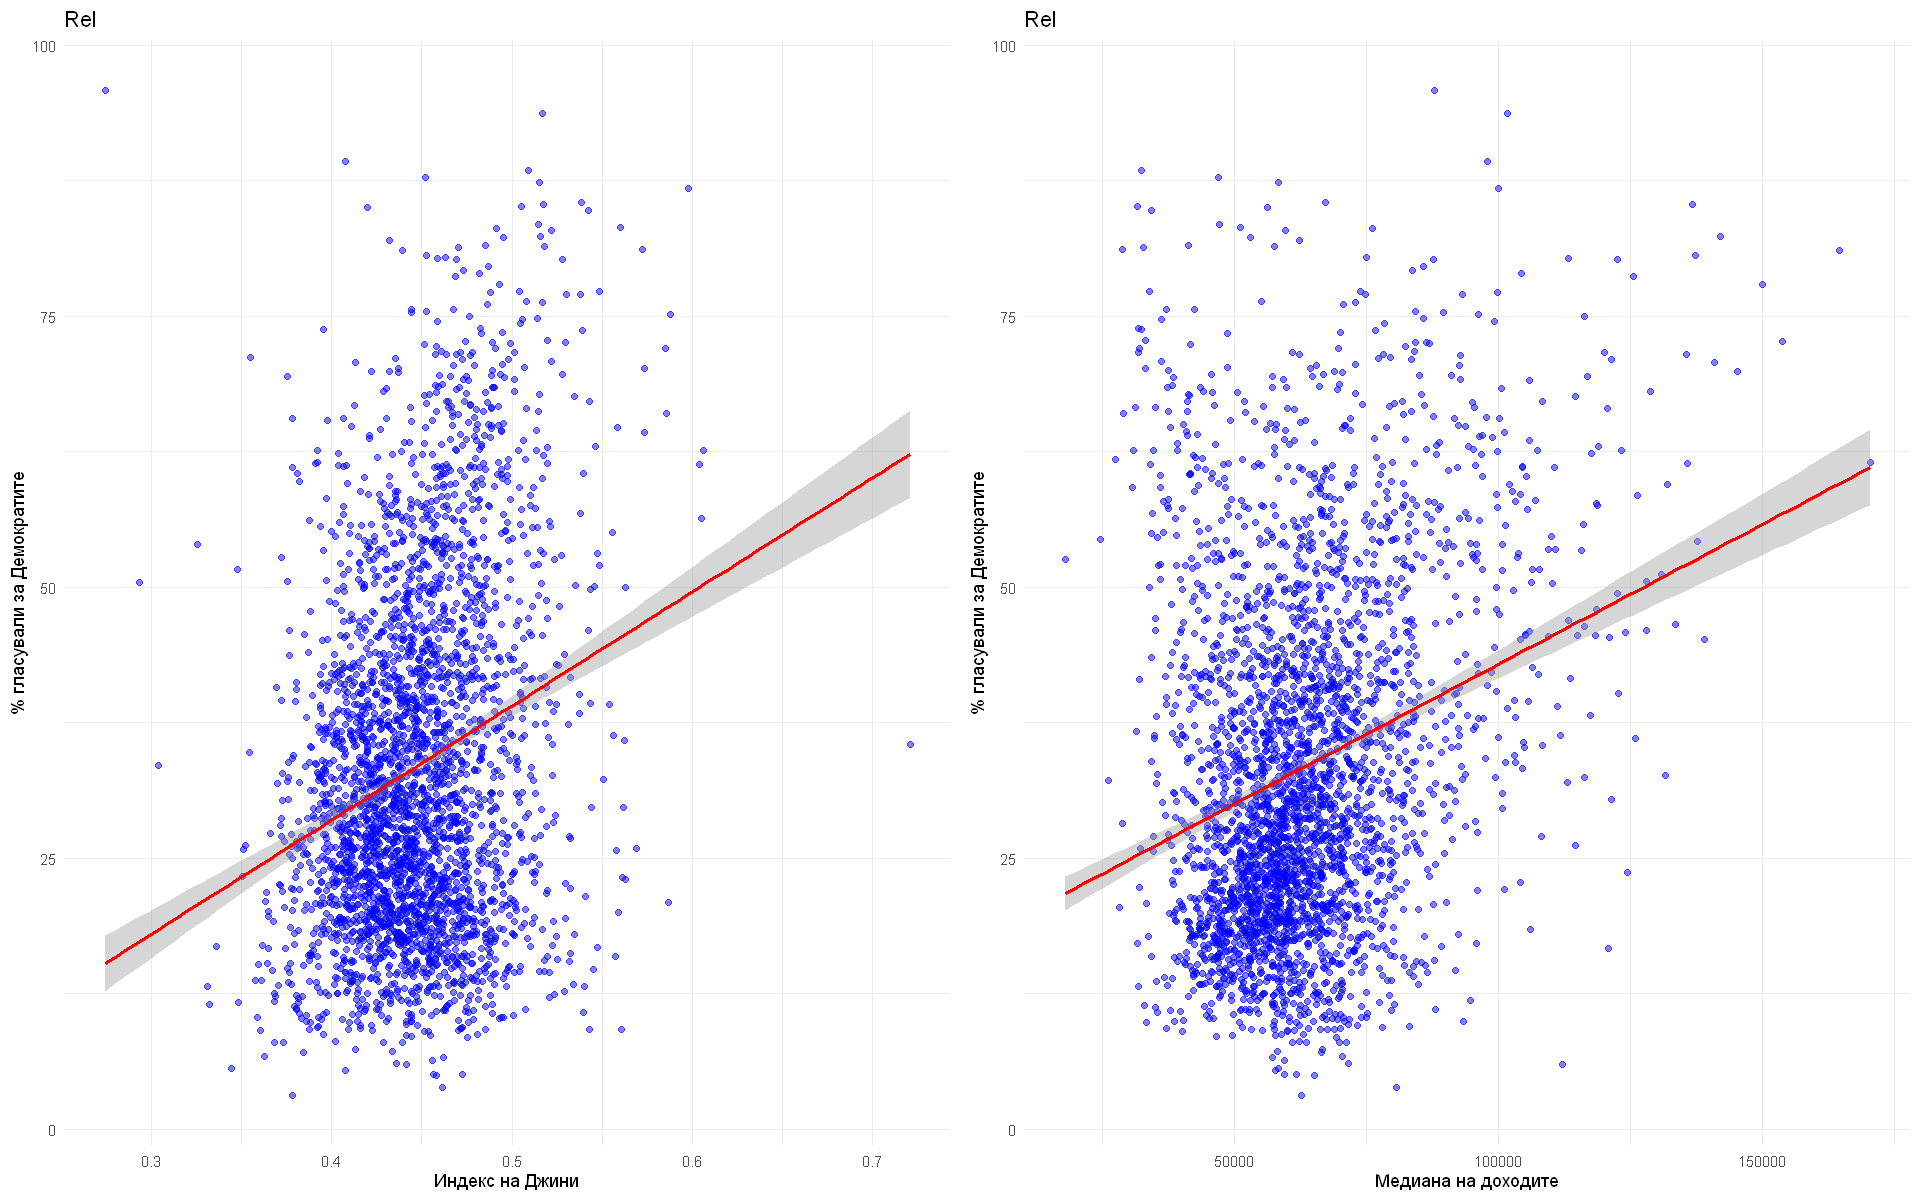

In [15]:
dem_gini <- ggplot(data, aes(x = Gini.Index, y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(title = "Rel", x = "Индекс на Джини", y = "% гласували за Демократите") + 
    theme_minimal()
dem_median_income <- ggplot(data, aes(x = Median.income..dollars., y = X2020.Democrat.vote..)) + 
    geom_point(alpha = 0.5, color = "blue") +
    geom_smooth(method = "lm", color = "red", se = TRUE) +
    labs(title = "Rel", x = "Медиана на доходите", y = "% гласували за Демократите") + 
    theme_minimal()
grid.arrange(dem_gini, dem_median_income, ncol=2, widths = c(1, 1))

Тук забелязваме следната тенденция - с увеличаването на медианата на доходите в даден окръг, се увеличава и процентът гласували за Демократите. Можем да забележим, че именно това доказва по-високите изборни резултати на партията в големите градове и техните покрайнини, тъй като те са с по-висок индекс на Джини, поради по-високите нива на бедност там